## Section One: GeoSpatial Data Processing

In this section, you will implement a pipeline to generate a time series of vegetation indices for a
given Area of Interest (AOI). The vegetation indices we will be looking at are the NDWI and the
MSI.


#### Objective:
Given:
- An AOI (given as GeoJSON).
- A vegetation index.
- A start and end date.

You must produce a **GeoTIFF file**, where:
- Each band corresponds to the selected vegetation index computed at a specific
acquisition date within the requested date range.
- The output GeoTIFF should have the same CRS as the input GeoJSON.


#### Requirements:
- We advise using Sentinel-2, but Landsat will also be accepted. **Important**: Clearly
explain your choice of data **preprocessing level** (e.g., Level-1C, Level-2A for
Sentinel-2, or L1/L2 for Landsat).
- You are free to choose the API, library, or provider you want. **Important**: Explain your
choice of API/provider and discuss its advantages and drawbacks.
- You are not expected to submit the generated GeoTIFFs. We will test your code by
running it against different AOIs and date ranges.


In [13]:
import pandas as pd
import geojson
import matplotlib.pyplot as plt
import numpy as np
# import rasterio
# from rasterio.plot import show

## Which processing level to use ?

https://gis.stackexchange.com/questions/385975/should-i-always-choose-sentinel-2-atmospheric-corrected-imagery

https://forum.step.esa.int/t/clarification-on-difference-between-l1c-and-l2a-data/24940/6

**API sentinelhub**

https://docs.sentinel-hub.com/api/latest/data/

https://sentinelhub-py.readthedocs.io/en/latest/examples/data_collections.html

https://sentiwiki.copernicus.eu/web/s2-applications

In [5]:
from sentinelhub import DataCollection
# for collection in DataCollection.get_available_collections():
#     print(collection)

DataCollection.SENTINEL2_L2A

<DataCollection.SENTINEL2_L2A: DataCollectionDefinition(
  api_id: sentinel-2-l2a
  catalog_id: sentinel-2-l2a
  wfs_id: DSS2
  service_url: https://services.sentinel-hub.com
  collection_type: Sentinel-2
  sensor_type: MSI
  processing_level: L2A
  bands: (Band(name='B01', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B02', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B03', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B04', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B05', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B06', units=(<Unit.RE

In [15]:
import json

with open('../AOI_Rubicon.geojson', 'r') as file:
    geojson_data = json.load(file)["features"][0]["geometry"]

print(geojson_data)



{'coordinates': [[[5.429163466084987, 46.13806674872461], [5.429163466084987, 45.50223271109695], [7.127353602241698, 45.50223271109695], [7.127353602241698, 46.13806674872461], [5.429163466084987, 46.13806674872461]]], 'type': 'Polygon'}


In [ ]:
from sentinelhub import CRS, MimeType, SentinelHubRequest, SHConfig, Geometry
import os

# Write your credentials here if you haven't already put them into config.toml
CLIENT_ID = os.environ["SH_CLIENT_ID"]
CLIENT_SECRET = os.environ["SH_CLIENT_SECRET"]

config = SHConfig()
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

sh_geometry = Geometry.from_geojson(geojson_data, crs=CRS.WGS84)

time_interval = "2020-07-15", "2020-07-16"

evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02", "B03", "B04"]
        }],
        output: {
            bands: 3
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_nvdi = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [(sample.B08 - sample.B04) / (sample.B08 + sample.B04)];
}
"""

evalscript_evi="""
//VERSION=3
function setup() {
    return {
        input: ["B02", "B04", "B08"],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
        }
    };
}

function evaluatePixel(samples) {
    return [2.5 * (samples.B08 - samples.B04) / ((samples.B08 + 6.0 * samples.B04 - 7.5 * samples.B02) + 1.0)]
"""
catalog = SentinelHubCatalog(config=config)

request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=sh_geometry,
    config=config,
)

image = request.get_data()[0]

255 0


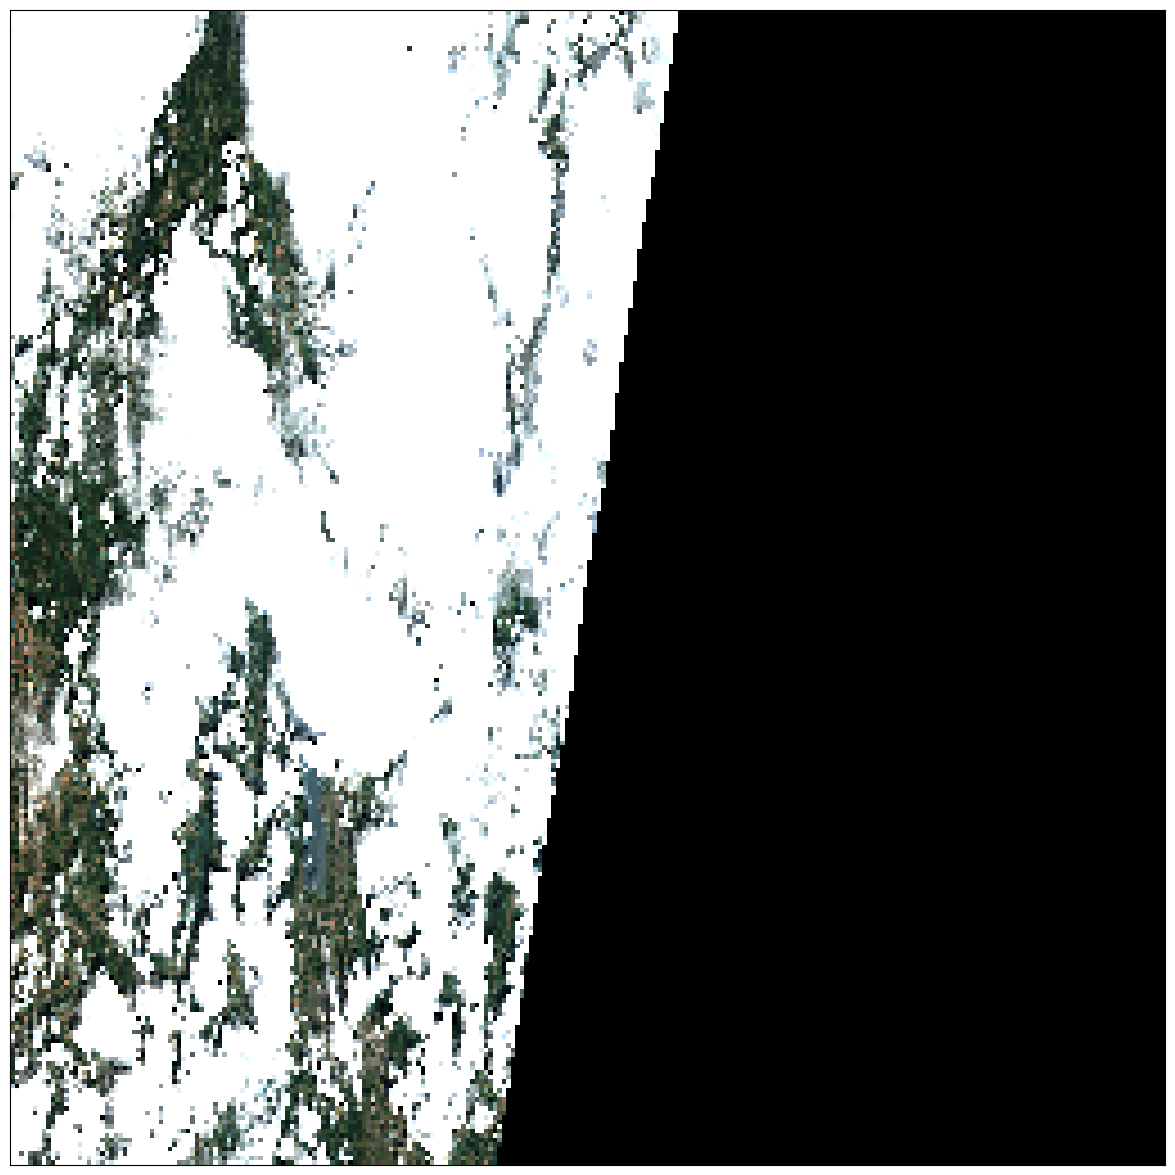

In [20]:
# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from rubicon_cs.utils import plot_image
print(image.max(), image.min())
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [4]:
print(image.shape)

(466, 700, 3)


In [2]:

from sentinelhub import (
    SentinelHubRequest, SentinelHubCatalog, SHConfig,
    CRS, Geometry, DataCollection, MimeType
)
import json
import numpy as np
import rasterio
import os

with open('../AOI_Rubicon.geojson', 'r') as file:
    geojson_data = json.load(file)["features"][0]["geometry"]

print(geojson_data)

geometry = Geometry.from_geojson(geojson_data, crs=CRS.WGS84)

# Set up config
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

# Catalog to find acquisition dates
catalog = SentinelHubCatalog(config=config)

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    geometry=geometry,
    time=("2020-07-01", "2020-08-01"),
    filter='eo:cloud_cover < 20',
    fields={"include": ["properties.datetime"], "exclude": []}
)

acquisition_dates = [item["properties"]["datetime"][:10] for item in search_iterator]

evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02", "B03", "B04"]
        }],
        output: {
            bands: 3
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_nvdi = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [(sample.B08 - sample.B04) / (sample.B08 + sample.B04)];
}
"""

evalscript_evi="""
//VERSION=3
function setup() {
    return {
        input: ["B02", "B04", "B08"],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
        }
    };
}

function evaluatePixel(samples) {
    return [2.5 * (samples.B08 - samples.B04) / ((samples.B08 + 6.0 * samples.B04 - 7.5 * samples.B02) + 1.0)]
"""

ndvi_stack = []
transform = None
crs = None

for date in acquisition_dates:
    request = SentinelHubRequest(
        evalscript=evalscript_nvdi,
        input_data=[SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=(date, date)
        )],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=geometry,
        config=config
    )
    ndvi_img = request.get_data()[0]
    ndvi_stack.append(ndvi_img.squeeze())  # remove extra dimension

    # After retrieving the first image, use it to get metadata
    if transform is None:
        bounds = geometry.bbox
        print(f"Bounding Box: {bounds}")

        # Ensure the correct ordering of shape dimensions: (height, width)
        if len(ndvi_img.shape) == 3:
            height, width = ndvi_img.shape[1], ndvi_img.shape[2]
        else:
            height, width = ndvi_img.shape[0], ndvi_img.shape[1]
        
        # Create the transformation using the bounding box and image shape
        transform = rasterio.transform.from_bounds(*bounds, width, height)
        crs = geometry.crs.pyproj_crs()

# Save as GeoTIFF
with rasterio.open(
    "ndvi_timeseries.tif", "w",
    driver="GTiff",
    height=ndvi_stack[0].shape[0],
    width=ndvi_stack[0].shape[1],
    count=len(ndvi_stack),
    dtype=np.float32,
    crs=crs,
    transform=transform
) as dst:
    for i, (ndvi, date) in enumerate(zip(ndvi_stack, acquisition_dates), start=1):
        # Write each NDVI band to the GeoTIFF
        dst.write(ndvi.astype(np.float32), i)
        
        # Add the acquisition date as a description for each band
        date_metadata = f"Acquisition Date: {date}"
        dst.update_tags(i, DATE=date)


{'coordinates': [[[5.429163466084987, 46.13806674872461], [5.429163466084987, 45.50223271109695], [7.127353602241698, 45.50223271109695], [7.127353602241698, 46.13806674872461], [5.429163466084987, 46.13806674872461]]], 'type': 'Polygon'}


/tmp/ipykernel_60130/1710974049.py:104: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(f"Bounding Box: {bounds}")


Bounding Box: 5.429163466084987,45.50223271109695,7.127353602241698,46.13806674872461


In [ ]:
import rasterio.plot
import matplotlib.pyplot as plt


data_name = "merged_timeseries.tif"
with rasterio.open(data_name) as tiff:

    ncols = 2
    nrows = (tiff.count // ncols) + (1 if tiff.count % ncols != 0 else 0)

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 5 * nrows))
    axes = ax.flatten()
    
    # Loop through each band and plot it
    for i in range(tiff.count):
        # Read the data for the current band
        band_data = tiff.read(i + 1)
        
        # Retrieve the acquisition date for the current band
        band_metadata = tiff.tags(i + 1)
        acquisition_date = band_metadata.get("DATE", "No date available")
        
        # Plot the current band in the corresponding subplot
        axes[i].imshow(band_data, cmap='Greens')  # Use imshow for displaying the band
        axes[i].set_title(f"NDVI Index in AOI on {acquisition_date}", fontsize=10)    
        axes[i].axis('off')  # Turn off the axis

    plt.tight_layout()    
    plt.show()